### Master Thesis Project: Finding optimal EV charging infrastructure on DFDS routes
_________________________________________________________________________________________

#### Students: Jan Gaydoul & Emanuela Zucchetto

#### Code Part 1: Data Pre-processing, Exploratory Data Analysis, Feature Engineering and final datasets generation

This notebook contains ...

1) Loading the different data sources and merging them into one consolidated dataset 
2) Get a first overview of the data we are working with 
3) Checking missing values and dropping redundant variables
4) Feature Deep Dive
5) Feature Engineering
6)
7)
8)
9) 

This file outputs the three final datasets that are used as the basis for the further project:
1) df_deliveries:
2) df_routes:
3) df_locations:
______________________________________________________________________________________________________________

In [11]:
# Importing needed libraries

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import haversine as hs
import requests
import reverse_geocode

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

##### 1) Data Loading and Merging

In this first section the dataset by DFDS and a first exploration is done. The main action point deriving from that:
- df_with_legs_1 and df_with_legs_2 are concatenated, since they are consecutive from a time perspective 
- the resulting data frame is merged with df based on BookingId, as it contains additional features. This is due to the fact that the files are pulled from different services within DFDS data infrastructure

In [12]:
# Read three initial datasets (csv files) 
# Please note that the path has to be modified based on the location of the files on your local device. 

df = pd.read_csv("/Users/emanuelazucchetto/Desktop/Copenhagen Business School/Thesis/03_Data/Results.csv")
df_with_legs_1 = pd.read_csv("/Users/emanuelazucchetto/Desktop/Copenhagen Business School/Thesis/03_Data/booking_with_legs_2021-2022.csv")
df_with_legs_2 = pd.read_csv("/Users/emanuelazucchetto/Desktop/Copenhagen Business School/Thesis/03_Data/collections_bookings_with_legs_2022.csv")

In [13]:
# Creating copies of original datasets

df_backup = df.copy()
df_with_legs_1_backup = df_with_legs_1.copy()
df_with_legs_2_backup = df_with_legs_2.copy()

From the observation of the first rows of each dataset it is possible to note that while df_with_legs_1 and df_with_legs_2 have the same structure, df structure differs
In addition, the time frames of the datasets don't align 100%

In [14]:
df.head()

,BookingId,BookingNumber,PlannedFirstCollectionDate,PlannedLastDeliveryDate,ActualFirstCollectionDate,ActualLastDeliveryDate,CreationDate,OrganizationName,TrafficDescription,FirstCollectionFreightLocation,FirstCollectionFreightLocationCity,FirstCollectionFreightLocationPostalCode,FirstCollectionFreightLocationCountry,FirstCollectionFreightLocationLongitudePositionDD,FirstCollectionFreightLocationLatitudePositionDD,LastDeliveryFreightLocation,LastDeliveryFreightLocationCity,LastDeliveryFreightLocationPostalCode,LastDeliveryFreightLocationCountry,LastDeliveryFreightLocationLongitudePositionDD,LastDeliveryFreightLocationLatitudePositionDD,FullLoadIndicator,EmptyBookingIndicator,Customer Name,Customer City
0,6123633,petwarr16123633,2020-01-01 00:00:00.000,2020-01-01 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,2020-01-02 00:00:00.000,Peterborough,PET Warrington FL Reefer,RB NORTH WEST,Warrington,WA3 3JD,United Kingdom,-2.59099,53.46935,RB NORTH WEST,Warrington,WA3 3JD,United Kingdom,-2.59099,53.46935,N,N,RB NORTH WEST - SHUNTING,Warrington
1,6123634,gotdome16123634,2020-01-02 00:00:00.000,2020-01-02 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,2020-01-02 00:00:00.000,Gothenburg,GOT Area DLS,DHL VOLVO X-DOCK,Göteborg,418 79,Sweden,11.82177,57.71499,TAV,Göteborg,418 79,Sweden,11.82862,57.71873,Y,N,VOLVO CAR CORPORATION SHUTTLE,Göteborg
2,6123635,petwarr16123635,2020-01-01 00:00:00.000,2020-01-01 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,2020-01-02 00:00:00.000,Peterborough,PET Warrington FL Reefer,RB NORTH WEST,Warrington,WA3 3JD,United Kingdom,0.00000,0.00000,RB NORTH WEST,Warrington,WA3 3JD,United Kingdom,0.00000,0.00000,N,N,RB NORTH WEST - SHUNTING,Warrington
3,6123636,gotflua16123636,2020-01-02 00:00:00.000,2020-01-02 00:00:00.000,2020-01-03 00:00:00.000,2020-01-02 00:00:00.000,2020-01-02 00:00:00.000,Karlshamn,KAN Domestic,DHL VOLVO X-DOCK,Göteborg,418 79,Sweden,11.82177,57.71499,BSNRA_VCBC HF - VOLVO CARS BODY CO,Olofström,418 79,Sweden,14.51683,56.28538,Y,N,VOLVO CAR CORPORATION SHUTTLE,Göteborg
4,6123637,gotdome16123637,2020-01-02 00:00:00.000,2020-01-02 00:00:00.000,1900-01-01 00:00:00.000,1900-01-01 00:00:00.000,2020-01-02 00:00:00.000,Gothenburg,GOT International DLS,DHL VOLVO X-DOCK,Göteborg,418 79,Sweden,11.82177,57.71499,VOLVO CAR M3,Skövde,418 79,Sweden,13.87343,58.38001,Y,N,VOLVO CAR CORPORATION SHUTTLE,Göteborg


In [15]:
df_with_legs_1.head()

,BookingId,SubBookingName,SubBookingLegId,StartLegLocationId,EndLegLocationId,FromLocation,ToLocation,TransportId,StartRequestedDate,EndRequestedDate,GrossWeight,LoadMetres,CubicMetres,Length,Width,Height,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry
0,7399574,A,8266605,132168,124047,TESCO,GRAYRENTALS,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom
1,7399575,A,8266607,243727,27597,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom
2,7399576,A,8266606,243727,27597,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom
3,7399577,A,8266608,29361,108395,C/O GREENCORE FROZEN FOODS,BIDVEST,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom
4,7399578,A,8266609,29361,69407,C/O GREENCORE FROZEN FOODS,ALDI STORES LTD,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom


In [16]:
df_with_legs_2.head()

,BookingId,SubBookingName,SubBookingLegId,StartLegLocationId,EndLegLocationId,FromLocation,ToLocation,TransportId,StartRequestedDate,EndRequestedDate,GrossWeight,LoadMetres,CubicMetres,Length,Width,Height,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry
0,9031814,A,11006604,219248,45984,LANGDONS LIVERPOOL,HOPWELLS - HANDSWORTH,4297407.0,2022-01-04,2022-01-04,0.0,7.5,0.0,NaN,NaN,NaN,NaN,53.47114,-2.85863,Liverpool,United Kingdom,53.37030,-1.36706,Sheffield,United Kingdom
1,9031814,B,11006603,219248,313716,LANGDONS LIVERPOOL,A F BLAKEMORE - LEEDS,4297407.0,2022-01-04,2022-01-04,0.0,3.0,0.0,NaN,NaN,NaN,NaN,53.47114,-2.85863,Liverpool,United Kingdom,53.72657,-1.47493,LEEDS,United Kingdom
2,9031815,A,11006606,219248,226398,LANGDONS LIVERPOOL,BRAKE BROS LTD (IND-WARRINGTON),4297408.0,2022-01-04,2022-01-04,0.0,2.5,0.0,NaN,NaN,NaN,NaN,53.47114,-2.85863,Liverpool,United Kingdom,53.41519,-2.65811,Warrington,United Kingdom
3,9031815,B,11006605,219248,104866,LANGDONS LIVERPOOL,ICELAND - WARRINGTON,4297408.0,2022-01-04,2022-01-04,0.0,7.5,0.0,NaN,NaN,NaN,NaN,53.47114,-2.85863,Liverpool,United Kingdom,53.40374,-2.52728,Warrington,United Kingdom
4,9031816,A,11006607,494,268078,MCCAIN FOODS LTD,LINEAGE (PETERBOROUGH) GB,4298106.0,2022-01-04,2022-01-04,19436.0,0.0,0.0,NaN,NaN,NaN,NaN,52.55913,-0.17384,Peterborough - McCains,United Kingdom,52.53329,-0.30444,Peterborough - Lineage,United Kingdom


After having double-checked that the structure of df_with_legs_1 and df_with_legs_2 corresponds, the datasets are concatenated

In [17]:
# Check if two dfs with legs have the same columns (and if we therefore are able to merge them)

df_with_legs_1.columns == df_with_legs_2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [18]:
# From the BookingId we can see that df_with_legs_1/2 are consecutive --> since all columns are the same we can directly concatenate them 

print(df_with_legs_1["BookingId"].tail(), df_with_legs_2["BookingId"].head())

2314233    9031810
2314234    9031811
2314235    9031811
2314236    9031812
2314237    9031813
Name: BookingId, dtype: int64 0    9031814
1    9031814
2    9031815
3    9031815
4    9031816
Name: BookingId, dtype: int64


In [54]:
# Concatenating datasets so we can work with one consolidated dataset:

df_final = pd.concat([df_with_legs_1, df_with_legs_2], ignore_index = True)

In [21]:
# Consolidated dataset has ~5m rows and 25 columns

df_final.shape 

(5011926, 25)

There are different representations of the same booking in the two systems.  
Find example of BookingId 9031814 below:

In [15]:
# 1) In df, the bookings don't show sub-bookings ("legs"), which essentially constitute different steps in the delivery process

df[df['BookingId'] == 9031814]

,BookingId,BookingNumber,PlannedFirstCollectionDate,PlannedLastDeliveryDate,ActualFirstCollectionDate,ActualLastDeliveryDate,CreationDate,OrganizationName,TrafficDescription,FirstCollectionFreightLocation,FirstCollectionFreightLocationCity,FirstCollectionFreightLocationPostalCode,FirstCollectionFreightLocationCountry,FirstCollectionFreightLocationLongitudePositionDD,FirstCollectionFreightLocationLatitudePositionDD,LastDeliveryFreightLocation,LastDeliveryFreightLocationCity,LastDeliveryFreightLocationPostalCode,LastDeliveryFreightLocationCountry,LastDeliveryFreightLocationLongitudePositionDD,LastDeliveryFreightLocationLatitudePositionDD,FullLoadIndicator,EmptyBookingIndicator,Customer Name,Customer City
2703963,9031814,petcher19031814,2022-01-04 00:00:00.000,2022-01-04 00:00:00.000,2022-01-04 00:00:00.000,2022-01-04 00:00:00.000,2022-01-01 00:00:00.000,Peterborough,PET Chesterf-Dom FL Reefer,LANGDONS LIVERPOOL,Liverpool,L33 7YQ,United Kingdom,-2.85863,53.47114,A F BLAKEMORE - LEEDS,LEEDS,L33 7YQ,United Kingdom,-1.47493,53.72657,Y,N,STEF LANGDONS LTD,Bridgwater


In [20]:
# 2) In df_with_legs_1/2, every collection is divided into sub-bookings where applicable

df_final[df_final['BookingId'] == 9031814]

,BookingId,SubBookingName,SubBookingLegId,StartLegLocationId,EndLegLocationId,FromLocation,ToLocation,TransportId,StartRequestedDate,EndRequestedDate,GrossWeight,LoadMetres,CubicMetres,Length,Width,Height,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry
2314238,9031814,A,11006604,219248,45984,LANGDONS LIVERPOOL,HOPWELLS - HANDSWORTH,4297407.0,2022-01-04,2022-01-04,0.0,7.5,0.0,NaN,NaN,NaN,NaN,53.47114,-2.85863,Liverpool,United Kingdom,53.37030,-1.36706,Sheffield,United Kingdom
2314239,9031814,B,11006603,219248,313716,LANGDONS LIVERPOOL,A F BLAKEMORE - LEEDS,4297407.0,2022-01-04,2022-01-04,0.0,3.0,0.0,NaN,NaN,NaN,NaN,53.47114,-2.85863,Liverpool,United Kingdom,53.72657,-1.47493,LEEDS,United Kingdom


Given that the df_final contains the very relevant split in SubBookings, but df provides additional features, a join is performed 

In [55]:
# Next step is to add columns from dataset without legs that are missing in the new df_final 
# --> ["FullLoadIndicator", "EmptyBookingIndicator", "CustomerName"] are being merged using "BookingId"

df_final = pd.merge(df_final, df[['BookingId','FullLoadIndicator','EmptyBookingIndicator', 'Customer Name']],on = 'BookingId', how = 'left')

##### 2) General Overview

Here a very general overview on the consolidated dataset is provided

In [23]:
# Check if concatenating and merging worked out

df_final.head()

,BookingId,SubBookingName,SubBookingLegId,StartLegLocationId,EndLegLocationId,FromLocation,ToLocation,TransportId,StartRequestedDate,EndRequestedDate,GrossWeight,LoadMetres,CubicMetres,Length,Width,Height,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name
0,7399574,A,8266605,132168,124047,TESCO,GRAYRENTALS,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,Y,N,DFDS LOGISTICS LIMITED (WARRINGTON)
1,7399575,A,8266607,243727,27597,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY
2,7399576,A,8266606,243727,27597,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY
3,7399577,A,8266608,29361,108395,C/O GREENCORE FROZEN FOODS,BIDVEST,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,N,N,GREENCORE GROCERY LTD (LEEDS)
4,7399578,A,8266609,29361,69407,C/O GREENCORE FROZEN FOODS,ALDI STORES LTD,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,Y,N,GREENCORE GROCERY LTD (LEEDS)


In [24]:
# Print general information such as shape and column names

print(df_final.shape)
print(df_final.columns)

(5011926, 28)
Index(['BookingId', 'SubBookingName', 'SubBookingLegId', 'StartLegLocationId',
       'EndLegLocationId', 'FromLocation', 'ToLocation', 'TransportId',
       'StartRequestedDate', 'EndRequestedDate', 'GrossWeight', 'LoadMetres',
       'CubicMetres', 'Length', 'Width', 'Height', 'Temperature',
       'FromLatitude', 'FromLongtitude', 'FromCity', 'FromCountry',
       'ToLatitude', 'ToLongtitude', 'ToCity', 'ToCountry',
       'FullLoadIndicator', 'EmptyBookingIndicator', 'Customer Name'],
      dtype='object')


In [27]:
# Information on datatypes

df_final.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5011926 entries, 0 to 5011925
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   BookingId              int64  
 1   SubBookingName         object 
 2   SubBookingLegId        int64  
 3   StartLegLocationId     int64  
 4   EndLegLocationId       int64  
 5   FromLocation           object 
 6   ToLocation             object 
 7   TransportId            float64
 8   StartRequestedDate     object 
 9   EndRequestedDate       object 
 10  GrossWeight            float64
 11  LoadMetres             float64
 12  CubicMetres            float64
 13  Length                 float64
 14  Width                  float64
 15  Height                 float64
 16  Temperature            float64
 17  FromLatitude           float64
 18  FromLongtitude         float64
 19  FromCity               object 
 20  FromCountry            object 
 21  ToLatitude             float64
 22  ToLongtitude      

#### 3) Checking missing values and dropping redundant variables

Understanding the amount of null values helps in assessing the data of the quality provided and in determining which aspects can be analysed more extensively

In [26]:
# Checking the number of null values for each feature

df_final.isna().sum()

BookingId                      0
SubBookingName                 0
SubBookingLegId                0
FromLocation                   0
ToLocation                     8
StartRequestedDate         18968
EndRequestedDate           19277
Temperature              4066738
FromLatitude                   0
FromLongtitude                 0
FromCity                       1
FromCountry                96415
ToLatitude                     0
ToLongtitude                   0
ToCity                        19
ToCountry                  80797
FullLoadIndicator         619661
EmptyBookingIndicator     619661
Customer Name             619661
dtype: int64

a) **"TransportId"**: around 40% missing   
 _How to handle_: drop variable (not used anyways)  
   
b) **"StartRequestedDate"/ "EndRequestedDate"**: around 0.3% nulls   
 Only very small amount of data missing, so it won't affect the seasonal analyses   
 _How to handle_: Keep variables and also don't drop rows, as the routes should still be analyzed  
  
c) **"Length", "Width", "Height"** : Close to 80% missing values  
 _How to handle_: drop variables  
  
d) **"Temperature"**: Close to 80% missing values   
 _How to handle_: Keep as it could provide information on the type of goods transported
  
e) **"FullLoadIndicator", "EmptyBookingIndicator", "Customer Name"**: 619.661 missing   
 _How to handle_: Keep as it could provide information on the type of loads 
  
f) **"FromCountry" and "ToCountry"**: Around 1.5% missing   
 _How to handle_: geoencode to find out respective values

In [24]:
# Dropping variables that are not needed for the analysis

# Creating list of columns to drop
columns_to_drop = ["StartLegLocationId", "EndLegLocationId", "TransportId", "LoadMetres", "CubicMetres", "Length", "Width", "Height", "GrossWeight"]

# Dropping columns
df_final = df_final.drop(columns_to_drop, axis = 1)

# Check dataset 
df_final.head()

,BookingId,SubBookingName,SubBookingLegId,FromLocation,ToLocation,StartRequestedDate,EndRequestedDate,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name
0,7399574,A,8266605,TESCO,GRAYRENTALS,2020-12-31,2020-12-31,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,Y,N,DFDS LOGISTICS LIMITED (WARRINGTON)
1,7399575,A,8266607,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,2020-12-31,2020-12-31,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY
2,7399576,A,8266606,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,2020-12-31,2020-12-31,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY
3,7399577,A,8266608,C/O GREENCORE FROZEN FOODS,BIDVEST,2020-12-31,2020-12-31,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,N,N,GREENCORE GROCERY LTD (LEEDS)
4,7399578,A,8266609,C/O GREENCORE FROZEN FOODS,ALDI STORES LTD,2020-12-31,2020-12-31,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,Y,N,GREENCORE GROCERY LTD (LEEDS)


#### 4) Feature Deep Dive

In [25]:
# Listing the columns in the dataset

columns = list(df_final.columns)
print(columns)

['BookingId', 'SubBookingName', 'SubBookingLegId', 'FromLocation', 'ToLocation', 'StartRequestedDate', 'EndRequestedDate', 'Temperature', 'FromLatitude', 'FromLongtitude', 'FromCity', 'FromCountry', 'ToLatitude', 'ToLongtitude', 'ToCity', 'ToCountry', 'FullLoadIndicator', 'EmptyBookingIndicator', 'Customer Name']


4.1) "BookingId"

There is a unique ID for every delivery. Sometimes it includes more than one "Leg" (which is the reason some IDs span over several rows)

In [32]:
# Counting the number of unique IDs

df_final['BookingId'].nunique() # ~3.3m unique BookingIDs

3322128

Finding how many subBookings are present for each actual Booking

In [40]:
# Counting the number of SubBookings for each BookingId
id_counts = df_final['BookingId'].value_counts()

# Create a new DataFrame to hold the results
id_result = pd.DataFrame({'count': id_counts})

id_result

,count
8382237,135
8708339,134
8818872,131
8403071,129
8862355,128
...,...
8665926,1
8665927,1
8665928,1
8665929,1


Counting how many times bookings with a certain number of SubBookings appear

In [41]:
# Add a new column indicating how many times each ID appears
id_result['frequency'] = id_result.groupby('count')['count'].transform('count')

# Keep only the unique frequency counts
id_result = id_result.drop_duplicates(subset = 'count').sort_values('frequency', ascending = False)

# Print the result
print(id_result)

          count  frequency
10141763      1    2925778
10394945      2     253879
7759452       3      48401
7677843       4      23573
8516401       5      10653
...         ...        ...
7814589     123          1
8556900     119          1
8369876     115          1
8920862     110          1
8382237     135          1

[128 rows x 2 columns]


4.2) "SubBookingName"

Counting the frequency of appearance of each SubBookingName. The alphabet letter does not have a full correspondence to the number of subBookings in the Booking beacuse there is no ensured consistency in how this variable is inputted in the system

In [34]:
# SubBookingName feature Gives information whether one delivery is sub-divided into multiple sub-bookings
# The vast majority of deliveries only consists of one booking

df_final["SubBookingName"].value_counts()

A    4619213
B     244863
C      90890
D      35139
E      13490
F       4746
G       1765
H        846
I        417
J        244
K        134
L         94
M         30
N         18
O          8
P          4
R          4
Q          4
S          4
U          3
T          3
V          3
W          2
Y          1
X          1
Name: SubBookingName, dtype: int64

4.3) "FromLocation" & 4.4) "ToLocation"

These two variables indicate the starting and ending location, in string form.


_Note_: In the dataset made available to the examiners these columns will result already encoded, as they contain sensitive data for DFDS. However, the process is provided below commented. Also, a version of the dataset with both encoded and non encoded variables is created, in order to be able to match back each encoding with the corresponding destination, if needed

In [56]:
# Encode senders (FromLocation) and receivers (ToLocation) from deliveries for anonymization purposes
# as they usually contain customer information

labelencoder = LabelEncoder()


df_final["FromLocationString"] = df_final["FromLocation"]
df_final["ToLocationString"] = df_final["ToLocation"]

#
df_final["FromLocation"] = labelencoder.fit_transform(df_final["FromLocationString"])
df_final["ToLocation"] = labelencoder.fit_transform(df_final["ToLocationString"])

df_final.head()

,BookingId,SubBookingName,SubBookingLegId,StartLegLocationId,EndLegLocationId,FromLocation,ToLocation,TransportId,StartRequestedDate,EndRequestedDate,GrossWeight,LoadMetres,CubicMetres,Length,Width,Height,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name,FromLocationString,ToLocationString
0,7399574,A,8266605,132168,124047,33917,32289,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,Y,N,DFDS LOGISTICS LIMITED (WARRINGTON),TESCO,GRAYRENTALS
1,7399575,A,8266607,243727,27597,9443,57716,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM
2,7399576,A,8266606,243727,27597,9443,57716,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM
3,7399577,A,8266608,29361,108395,5977,9831,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,N,N,GREENCORE GROCERY LTD (LEEDS),C/O GREENCORE FROZEN FOODS,BIDVEST
4,7399578,A,8266609,29361,69407,5977,3182,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,Y,N,GREENCORE GROCERY LTD (LEEDS),C/O GREENCORE FROZEN FOODS,ALDI STORES LTD


In [57]:
# Export to CSV and drop columns here

#df_final.to_csv('df_final_with_customers_internal.csv')

df_final=df_final.drop(['FromLocationString','ToLocationString'], axis=1)

4.5) "StartRequestedDate" & 4.6) "EndRequestedDate"

Next, the date when a delivery was requested (StartRequestedDate) vs. when it was actually picked up (EndRequestedDate) are analysed  
Firstly the variables are transformed to the appropriate format and then the wrong inputs are fixed


In [59]:
# First, bring date columns to datetime format before analysis

df_final['StartRequestedDate'] = pd.to_datetime(df_final['StartRequestedDate'])
df_final['EndRequestedDate'] = pd.to_datetime(df_final['EndRequestedDate'])

# Check if it worked
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5011926 entries, 0 to 5011925
Data columns (total 30 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   BookingId              int64         
 1   SubBookingName         object        
 2   SubBookingLegId        int64         
 3   StartLegLocationId     int64         
 4   EndLegLocationId       int64         
 5   FromLocation           int64         
 6   ToLocation             int64         
 7   TransportId            float64       
 8   StartRequestedDate     datetime64[ns]
 9   EndRequestedDate       datetime64[ns]
 10  GrossWeight            float64       
 11  LoadMetres             float64       
 12  CubicMetres            float64       
 13  Length                 float64       
 14  Width                  float64       
 15  Height                 float64       
 16  Temperature            float64       
 17  FromLatitude           float64       
 18  FromLongtitude        

Any evidently wrong date and mimatch between start and end date are analysed and wrong observations are dropped

In [60]:
# Add column for year in StartRequestedDate and EndRequestedDate

df_final['StartYear'] = df_final.StartRequestedDate.apply(lambda x:x.year)
df_final['EndYear'] = df_final.EndRequestedDate.apply(lambda x:x.year)

There seems to be some wrong inputs for the StartRequestedDate, as the dataset begins from the 1st January 2020

In [61]:
# Counting entries before 1st January 2020 for the StartYear variable

df_final[df_final.StartYear < 2020].shape

(64, 32)

EndRequestedDate contains less wrong inputs, so we can use this variable as basis in our analysis

In [62]:
# Counting entries before 1st January 2020 for the EndYear variable

df_final[df_final.EndYear < 2020].shape

(44, 32)

In [63]:
# Remove rows where the EndRequestedDate is before 2020 
df_final = df_final[df_final.EndYear >= 2020]

# Remove rows where the EndRequestedDate is after 2023
df_final = df_final[df_final.EndYear <= 2023]
df_final.shape

(4992586, 32)

When the StartYear and EndYear differ (18750 entries), it is mostly because of they happen in subsequent dates which belong to different years (31/12 vs 01/01), which is reasonable based on the definition of the StartRequestedDate and EndRequestedDate variable, therefore they are kept
 

In [70]:
# Mismatch between Sta
diff = df_final[df_final.StartYear != df_final.EndYear]
print(diff.shape)
diff.head()

(18984, 32)


,BookingId,SubBookingName,SubBookingLegId,StartLegLocationId,EndLegLocationId,FromLocation,ToLocation,TransportId,StartRequestedDate,EndRequestedDate,GrossWeight,LoadMetres,CubicMetres,Length,Width,Height,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name,FromLocationString,ToLocationString,StartYear,EndYear
1011,7400270,A,8267340,16292,8275,9225,21110,3434438.0,2020-12-31,2021-01-01,1.0,0.0,0.0,NaN,NaN,NaN,NaN,57.12226,-2.08894,Aberdeen,United Kingdom,55.72639,-3.95987,Larkhall,United Kingdom,Y,N,DFDS LOGISTICS LIMITED,DFDS ABERDEEN,DFDS LOGISTICS SCOTLAND LTD,2020.0,2021.0
1012,7400271,A,8267341,15483,8275,8661,21110,3434439.0,2020-12-31,2021-01-01,1.0,0.0,0.0,NaN,NaN,NaN,NaN,55.81563,-4.06952,UDDINGSTON,United Kingdom,55.72639,-3.95987,Larkhall,United Kingdom,Y,N,DFDS LOGISTICS LIMITED,DAWNFRESH SEAFOODS LIMITED,DFDS LOGISTICS SCOTLAND LTD,2020.0,2021.0
1015,7400273,A,8267344,16295,8275,9343,21110,3434441.0,2020-12-31,2021-01-01,1.0,0.0,0.0,NaN,NaN,NaN,NaN,53.57513,-0.11671,GRIMSBY,United Kingdom,55.72639,-3.95987,Larkhall,United Kingdom,Y,N,DFDS LOGISTICS LIMITED,DFDS LOGISTICS GRIMSBY LTD,DFDS LOGISTICS SCOTLAND LTD,2020.0,2021.0
1017,7400275,A,8267346,16421,117087,12331,31337,3434443.0,2020-01-02,2021-01-03,1.0,0.0,0.0,NaN,NaN,NaN,NaN,55.77058,-2.33837,DUNS,United Kingdom,55.82770,-3.98129,NORTH LANARKSHIRE,United Kingdom,Y,N,DFDS LOGISTICS LIMITED,FARNE SALMON & TROUT,GIST EUROCENTRAL,2020.0,2021.0
1449,7400530,A,8267622,60791,255659,17858,56428,3434587.0,2020-12-31,2021-01-05,21500.0,13.2,0.0,NaN,NaN,NaN,NaN,45.75822,12.81087,Portogruaro,Italy,57.68486,12.22925,Landvetter,Sweden,Y,N,FERCAM AUSTRIA GMBH,IT PL PORTOGRUARO PETCARE NPP,NESTLE PURINA PETCARE EMENA,2020.0,2021.0


In [71]:
# Remove the columns created before, as not necessary anymore

cols = ['StartYear','EndYear']
df_final = df_final.drop(cols, axis = 1)

After this data cleaning, weekly deliveries are plotted:

- The dips at the beginning of 2021, 2022 and 2023 are due to low activity surrounding end/beginning of year  
- The sudden rise in 10/2022 is due to DDFS acquiring another company in 2020/2021; it seems like the operations of this new part of DFDS have only been fed into the data systems around the end of 2022

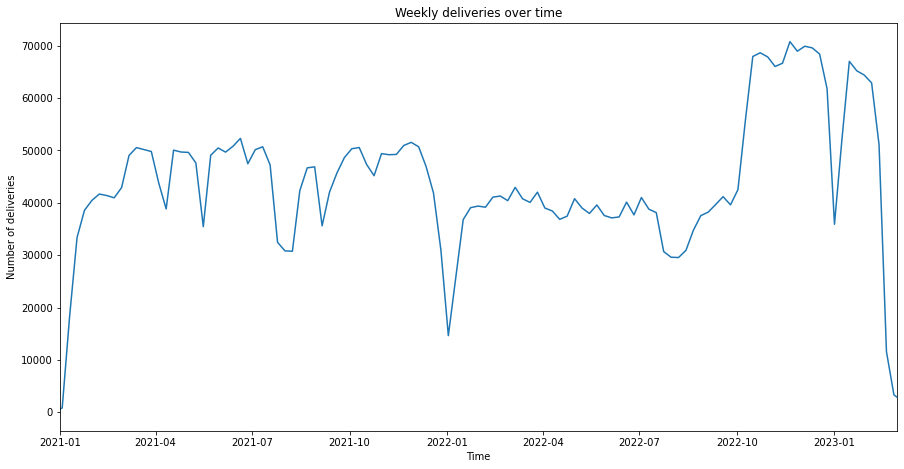

In [72]:
# Plotting WEEKLY number of deliveries
weekly_deliveries = df_final.groupby(pd.Grouper(key = 'EndRequestedDate', freq = 'W')).count()

# Setting figure size
fig = plt.figure(figsize = (15, 7.5))

# Plot the number of deliveries over time
plt.plot(weekly_deliveries.index, weekly_deliveries['BookingId'], label = 'Deliveries')

# Add axis labels and a title
plt.xlabel('Time')
plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2023-03-01'), None)
plt.ylabel('Number of deliveries')
plt.title('Weekly deliveries over time')

# Show the plot
plt.show()

The same data is plotten on a daily level:
- in addition to the behaviour shown previously, a weekly pattern can also be seen

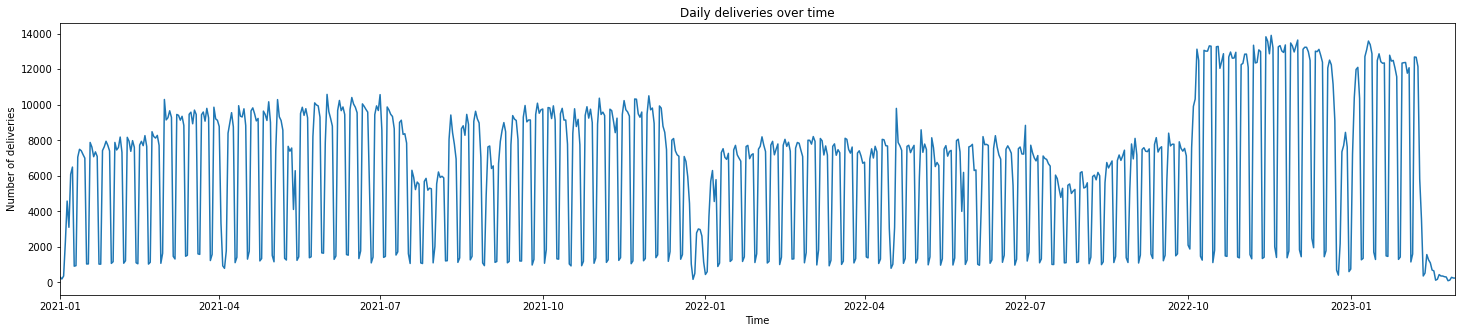

In [73]:
# Plotting DAILY number of deliveries 
daily_deliveries = df_final.groupby(pd.Grouper(key = 'StartRequestedDate', freq = 'D')).count()

# Setting figure size
fig = plt.figure(figsize=(25, 5))

# Plot the number of deliveries over time
plt.plot(daily_deliveries.index, daily_deliveries['BookingId'], label = 'Deliveries')

# Add axis labels and a title
plt.xlabel('Time')
plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2023-03-01'), None)
plt.ylabel('Number of deliveries')
plt.title('Daily deliveries over time')

# Show the plot
plt.show()

'EndRequestedDate' Should look similar as the distribution of 'StartRequestedDate', this is checked: 2m deliveries are being picked up at the date they are supposed to 

In [48]:
# Print the number of unique dates where delivery was planned and actually executed the same day

same_date = df_final['StartRequestedDate'] == df_final['EndRequestedDate']
print(same_date.sum()) #

2022981


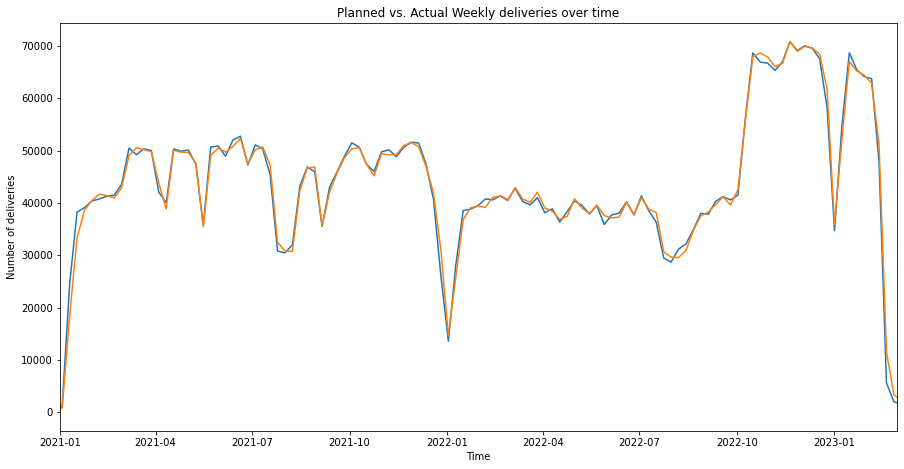

In [74]:
# Now checking if this is also visible in a graph

# Plotting WEEKLY number of deliveries
weekly_deliveries_planned = df_final.groupby(pd.Grouper(key = 'StartRequestedDate', freq = 'W')).count()
weekly_deliveries_actual = df_final.groupby(pd.Grouper(key = 'EndRequestedDate', freq = 'W')).count()

# Setting figure size
fig = plt.figure(figsize=(15, 7.5))

# Plot the number of deliveries over time
plt.plot(weekly_deliveries_planned.index, weekly_deliveries_planned['BookingId'], label = 'Planned Deliveries')
plt.plot(weekly_deliveries_actual.index, weekly_deliveries_actual['BookingId'], label = 'Actual Deliveries')

# Add axis labels and a title
plt.xlabel('Time')
plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2023-03-01'), None)
plt.ylabel('Number of deliveries')
plt.title('Planned vs. Actual Weekly deliveries over time')

# Show the plot
plt.show()

4.8) "Temperature"

In [50]:
# = Temperature of the delivery;
# -> 81.1% missing values, so careful with analyses

df_final['Temperature'].isna().sum() / len(df_final) * 100 

81.41464163060986

In [51]:
df_final['Temperature'].describe()

count    927890.000000
mean         -7.597398
std          15.614036
min         -40.000000
25%         -22.000000
50%          -5.000000
75%           0.000000
max          99.000000
Name: Temperature, dtype: float64

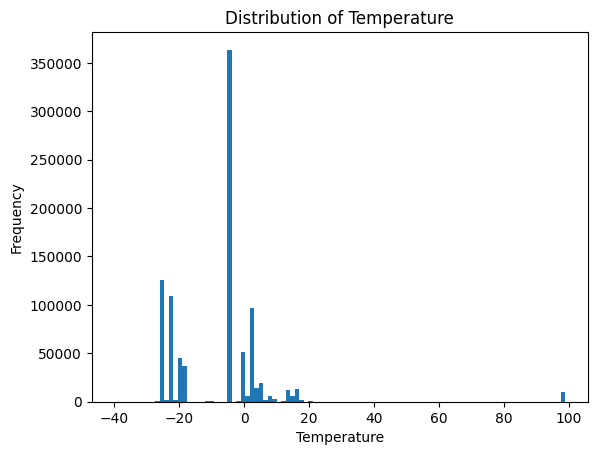

In [52]:
plt.hist(df_final['Temperature'], bins=100)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature')
plt.show()

**Note:**

There are two types of transports: Warm and cold. These have to be differentiated as cold transports have less reach. 
Find the creation of a new variable for frozen loads in "Feature Engineering" part below. 

4.9) "FromLatitude" and 4.10) "FromLongtitude" 

In [53]:
# = Information about the latitude and longitude points where a booking/delivery departs from 

# No analyses in here; see geographical visualization in Tableau
# Will be used to calculate distances below in feature engineering part

In [54]:
# Rename longitude column to vanish typo: 
df_final.rename(columns = {"FromLongtitude": "FromLongitude"}, inplace = True)

4.11) "FromCity"

In [55]:
# = City where a booking/delivery departs from 

# Only used for vizualisation purposes in Tableau

4.12) "FromCountry"

In [56]:
# = Country where a booking/delivery departs from 

# There are quite some missing values in this variable due to the merge. 

df_final["FromCountry"].isna().sum()

88101

In [57]:
# Let's fill the gaps by reverse geocoding and get countries via the coordinates. 

# Define a function to get the country from the latitude and longitude columns

def get_from_country(row):
    if pd.isnull(row['FromCountry']):
        coordinates = (row['FromLatitude'], row['FromLongitude']), (0, 0)
        address = reverse_geocode.search(coordinates)[0]
        return address['country']
    else:
        return row['FromCountry']

In [58]:
# Apply the function

df_final['FromCountry'] = df_final.apply(get_from_country, axis = 1)

In [59]:
# Check again for missing values

df_final["FromCountry"].isna().sum()

0

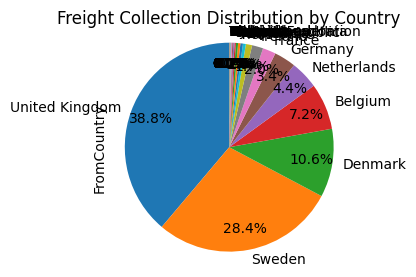

In [60]:
# Now let's visualize the variable

from_country = df_final['FromCountry'].value_counts()

from_country.plot(kind = 'pie', 
                  figsize = (3, 3), 
                  autopct = '%1.1f%%', 
                  startangle = 90,
                  pctdistance = 0.8,
                  labeldistance = 1.1)

plt.axis('equal')
plt.title('Freight Collection Distribution by Country')
plt.show()

4.13) "ToLatitude" and 4.14) "ToLongtitude"

In [61]:
# = Information about the latitude and longitude point where a booking/delivery is headed

# No analyses in here; see geographical visualization in Tableau
# Will be used to calculate distances below in feature engineering part

In [62]:
# Rename longitude column to vanish typo: 
df_final.rename(columns = {"ToLongtitude": "ToLongitude"}, inplace = True)

In [63]:
# Removing rows with latitude and longitude = 0.00 (due to human error) 
# --> because that corresponds to NullIsland and so the returned country = Ghana

df_final = df_final[df_final.FromLongitude != 0.000000]
df_final = df_final[df_final.ToLongitude != 0.000000]

In [64]:
df_final.shape

(4973604, 20)

4.15) "ToCity"

In [65]:
# = City where a booking/delivery is headed

# Only used for vizualisation purposes in Tableau

4.16) "ToCountry"

In [66]:
# = Country where a booking/delivery is headed

# There are quite some missing values in this variable due to the merge. 

df_final["ToCountry"].isna().sum()

54190

In [67]:
# Let's fill the gaps by reverse geocoding and get countries via the coordinates. 

# Define a function to get the country from the latitude and longitude columns
def get_to_country(row):
    if pd.isnull(row['ToCountry']):
        coordinates = (row['ToLatitude'], row['ToLongitude']), (0, 0)
        address=reverse_geocode.search(coordinates)[0]
        return address['country']
    else:
        return row['ToCountry']

In [68]:
# Applying the Function
df_final['ToCountry'] = df_final.apply(get_to_country, axis=1)

In [69]:
# Check again for missing values
df_final["ToCountry"].isna().sum()

0

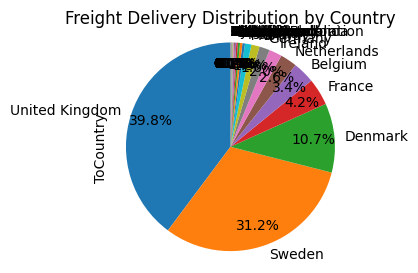

In [70]:
# Now let's visualize the variable

to_country = df_final['ToCountry'].value_counts()

to_country.plot(kind = 'pie', 
                  figsize = (3, 3), 
                  autopct = '%1.1f%%', 
                  startangle = 90,
                  pctdistance = 0.8,
                  labeldistance = 1.1)

plt.axis('equal')
plt.title('Freight Delivery Distribution by Country')
plt.show()

4.17) "FullLoadIndicator"

In [71]:
# = Indicates whether a load was "full"

# Checking loads counts

print('Nan:',df_final.FullLoadIndicator.isna().sum())
df_final.FullLoadIndicator.value_counts()

Nan: 584367


Y    2515263
N    1873974
Name: FullLoadIndicator, dtype: int64

In [72]:
# Binary encoding "FullLoadIndicator" from Y/N to 1/0

labelencoder = preprocessing.LabelEncoder()

df_final["FullLoadIndicator"] = df_final["FullLoadIndicator"].astype(str)
df_final["FullLoadIndicator"] = df_final["FullLoadIndicator"].map({'Y': 1, 'N': 0})

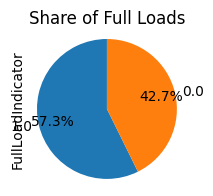

In [73]:
full_loads = df_final['FullLoadIndicator'].value_counts()

full_loads.plot(kind = 'pie', 
                            figsize = (2, 2), 
                            autopct = '%1.1f%%', 
                            startangle = 90,
                            pctdistance = 0.8,
                            labeldistance = 1.1)

plt.axis('equal')
plt.title('Share of Full Loads')
plt.show()

4.18) "EmptyBookingIndicator"

In [74]:
df_final['EmptyBookingIndicator'].value_counts()

N    4389237
Name: EmptyBookingIndicator, dtype: int64

In [75]:
# Binary encoding "EmptyBookingIndicator" from Y/N to 1/0

labelencoder = preprocessing.LabelEncoder()

df_final["EmptyBookingIndicator"] = df_final["EmptyBookingIndicator"].astype(str)
df_final["EmptyBookingIndicator"] = df_final["EmptyBookingIndicator"].map({'Y': 1, 'N': 0})

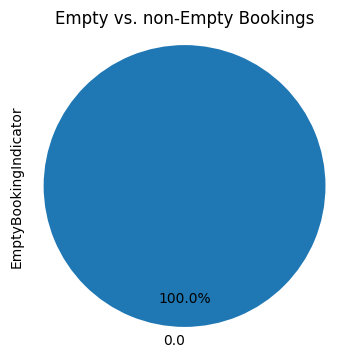

In [128]:
# = Gives information about "empty loads"; mostly trucks heading back to DFDS entities after a delivery

empty_booking = df_final['EmptyBookingIndicator'].value_counts()

empty_booking.plot(kind = 'pie', 
                            figsize = (4, 4), 
                            autopct = '%1.1f%%', 
                            startangle = 90,
                            pctdistance = 0.8,
                            labeldistance = 1.1)

plt.axis('equal')
plt.title('Empty vs. non-Empty Bookings')
plt.show()

# No empty bookings in new dataset?

4.19) "Customer Name"

In [76]:
# = the name of a customer 

df_final.rename(columns = {"Customer Name": "CustomerName"}, inplace = True)
# Counting unique number of customers:
df_final["CustomerName"].nunique()

12883

In [77]:
# Encoding Customer Name for anonymization purposes

df_final["CustomerName"] = labelencoder.fit_transform(df_final["CustomerName"])
df_final.head()

,BookingId,SubBookingName,FromLocation,ToLocation,StartRequestedDate,EndRequestedDate,Temperature,FromLatitude,FromLongitude,FromCity,FromCountry,ToLatitude,ToLongitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,CustomerName,FromLocationString,ToLocationString
0,7399574,A,33917,32289,2020-12-31,2020-12-31,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,1.0,0.0,2966,TESCO,GRAYRENTALS
1,7399575,A,9443,57716,2020-12-31,2020-12-31,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8183,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM
2,7399576,A,9443,57716,2020-12-31,2020-12-31,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8183,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM
3,7399577,A,5977,9831,2020-12-31,2020-12-31,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,0.0,0.0,4737,C/O GREENCORE FROZEN FOODS,BIDVEST
4,7399578,A,5977,3182,2020-12-31,2020-12-31,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,1.0,0.0,4737,C/O GREENCORE FROZEN FOODS,ALDI STORES LTD


#### 5) Feature Engineering

5.1) "DomesticDelivery"

In [78]:
# = equals 1 if delivery is collected and delivered within the same country, 0 if otherwise

df_final['DomesticDelivery'] = (df_final['FromCountry'] == df_final['ToCountry']).astype(int)
df_final.head()

,BookingId,SubBookingName,FromLocation,ToLocation,StartRequestedDate,EndRequestedDate,Temperature,FromLatitude,FromLongitude,FromCity,FromCountry,ToLatitude,ToLongitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,CustomerName,FromLocationString,ToLocationString,DomesticDelivery
0,7399574,A,33917,32289,2020-12-31,2020-12-31,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,1.0,0.0,2966,TESCO,GRAYRENTALS,1
1,7399575,A,9443,57716,2020-12-31,2020-12-31,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8183,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,1
2,7399576,A,9443,57716,2020-12-31,2020-12-31,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8183,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,1
3,7399577,A,5977,9831,2020-12-31,2020-12-31,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,0.0,0.0,4737,C/O GREENCORE FROZEN FOODS,BIDVEST,1
4,7399578,A,5977,3182,2020-12-31,2020-12-31,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,1.0,0.0,4737,C/O GREENCORE FROZEN FOODS,ALDI STORES LTD,1


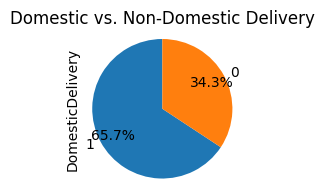

In [79]:
domestic_delivery = df_final['DomesticDelivery'].value_counts()

domestic_delivery.plot(kind = 'pie', 
                            figsize = (2, 2), 
                            autopct = '%1.1f%%', 
                            startangle = 90,
                            pctdistance = 0.8,
                            labeldistance = 1.1)

plt.axis('equal')
plt.title('Domestic vs. Non-Domestic Delivery')
plt.show()

In [ ]:
# We want to know whether a load is frozen or not, as this has major implications on the reach of the truck. 
# That's why we binary encode the "temperature" feature 
#ADD INFO ABOUT REFREGERATED GOODS

# Create the new "frozen_load" column using numpy.where
df_final['FrozenLoad'] = np.where(df_final['Temperature'] < 0, 1, 0)

In [ ]:
frozen_load = df_final['FrozenLoad'].value_counts()

frozen_load.plot(kind = 'pie', 
                        figsize = (2, 2), 
                        autopct = '%1.1f%%', 
                        startangle = 90,
                        pctdistance = 0.8,
                        labeldistance = 1.1)

plt.axis('equal')
plt.title('Share of frozen loads')
plt.show()

In [82]:
# Save df_final to .csv file 

df_final.to_csv('df_final_temp.csv')

In [ ]:
### BREAKER     

# Make file available as upload so examiners (technically) can skip first  part, upload file here, and work from there
# df_final = pd.read_csv('df_final_temp.csv')

In [80]:
# Identify which BookingId are present multiple times, meaning that the journey is formed by multiple legs
multi_legs = df_final[df_final.groupby('BookingId')['BookingId'].transform('size') > 1]

In [15]:
# Same operation, but now filtering for bookings with only one leg
single_leg = df_final[df_final.groupby('BookingId')['BookingId'].transform('size') <= 1]

In [83]:
# Ensuring the data is corrected
# Count of values > 1
print(df_final['BookingId'].value_counts().loc[lambda x : x>1].sum())

# Matches with new df shape
multi_legs.shape[0]

2062158


2062158

In [84]:
# Creating a new dataframe where to store the fized legs
fixed=pd.DataFrame()

In [ ]:
### DONT RUN: Output .csv provided later


# For each relevant element the ending value of one intermediate leg is used as starting value for the following one 
#def fix_legs(df):
#    fixed=pd.DataFrame()
#    for i in df.BookingId.unique():
#        temp=df[df.BookingId==i]    
#        temp.reset_index(inplace=True)
#        #make the "To" value of the previous leg the "From" value of the current leg
#        for ix in range(temp.shape[0]): 
            #all features that have a from/to version (maybe some columns can be dropped)   
            #temp.StartLegLocationId[ix+1]=temp.EndLegLocationId[ix]
            #temp.FromLocation[ix+1]=temp.ToLocation[ix]
#            temp.FromLatitude[ix+1]=temp.ToLatitude[ix]#- DONE
#            temp.FromLongtitude[ix+1]=temp.ToLongtitude[ix] #modify with ToLongitude when I get the latest data -DONE
            #temp.StartLegLocationId[ix+1]=temp.EndLegLocationId[ix]
#            temp.FromCity[ix+1]=temp.ToCity[ix]
            #temp.FromCountry[ix+1]=temp.ToCountry[ix] - DONE     
#        fixed=pd.concat([fixed,temp])
#    return fixed


In [ ]:
# Performing the operation on the dataset formed by multiple legs
multi_fixed=fix_legs(multi_legs)

In [18]:
# Ensuring that in recombining the dataset data is not lost
single_leg.shape[0]+multi_fixed.shape[0]

4973604

In [ ]:
# Putting  together data about single legs and fixed data about multiple legs
df_final=pd.concat([single_leg,multi_leg])

In [ ]:
# Make sure the dataset is in the right order by sorting BookingIds
df_final.sort_values(by=['BookingId'])

In [ ]:
### Exporting 

# df_final.to_csv('multiple_legs_fixed.csv')

In [4]:
# Make file available as upload so examiners (technically) can skip first  part, upload file here, and work from there
# df_final = pd.read_csv('multiple_legs_fixed.csv')

df_final = pd.read_csv('/Users/emanuelazucchetto/Desktop/Copenhagen Business School/Thesis/03_Data/data_multiple_legs_fixed.csv')

In [93]:
len(df_final)

4973604

In [92]:
# Checking whether  BookingIds are represented in the right way now 
df_final[df_final['BookingId'] == 9031814]

,BookingId,SubBookingName,SubBookingLegId,StartLegLocationId,EndLegLocationId,FromLocation,ToLocation,TransportId,StartRequestedDate,EndRequestedDate,GrossWeight,LoadMetres,CubicMetres,Length,Width,Height,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name
3888194,9031814,A,11006604,219248,45984,20181,36288,4297407.0,2022-01-04,2022-01-04,0.0,7.5,0.0,NaN,NaN,NaN,NaN,53.47114,-2.85863,Liverpool,United Kingdom,53.37030,-1.36706,Sheffield,United Kingdom,1.0,0.0,11014
3888195,9031814,B,11006603,219248,313716,20181,591,4297407.0,2022-01-04,2022-01-04,0.0,3.0,0.0,NaN,NaN,NaN,NaN,53.37030,-1.36706,Liverpool,United Kingdom,53.72657,-1.47493,LEEDS,United Kingdom,1.0,0.0,11014


5.2) "HaversineDistance"

In [ ]:
# = Calculate haversine distance between delivery points to have an approximation for delivery distance 
# Is later gonna be replaced by more exact distance we calculate via API

def get_distance_h(lat1, lon1, lat2, lon2):
    pickup = (lat1, lon1)
    dropoff = (lat2, lon2)
    return hs.haversine(pickup, dropoff)

# Apply the function to dataframe
df_final['HaversineDistance'] = df_final.apply(lambda row: get_distance_h(row['FromLatitude'], row['FromLongitude'], row['ToLatitude'], row['ToLongitude']), axis=1)
df_final.head()

In [ ]:
df_final['HaversineDistance'].describe()

Mean: 368 km 
Min.: 0 km
Max.: 8543 km

In [ ]:
# Plotting haversine distances

plt.hist(df_final["HaversineDistance"], bins = 100)
plt.xlabel("Driving distance (km)")
plt.ylabel("Frequency")
plt.title("Distribution of delivery distances")
plt.show()

In [ ]:
# Plotting again, but this time exclusing all deliveries >2,500km, as they usually include sea travel 

subset = df_final[(df_final['HaversineDistance'] < 2500)]

plt.hist(subset["HaversineDistance"], bins = 250)
plt.xlabel("Driving distance (km)")
plt.ylabel("Frequency")
plt.title("Distribution of delivery distances")
plt.show()

5.3) "RouteDistance"

= We calculate the route length of a delivery leveraging the Bing Maps API 

Knowing the distance of a delivery is crucial for us to know, as eTrucks have a limited reach and charging stations have to be placed accordingly 

In [139]:
# The dataset has ~5 million rows. However, we don't want to make 5 million calls to the APi. 
# This is why we extract the unique routes first. 
# Every unique set of the four coordinate variables equals a unique route. 

# 1) Creating dataframe with only the coordinates 
routes = df_final[['FromLatitude', 'FromLongitude', 'ToLatitude', 'ToLongitude']]

# 2) dropping duplicate rows
routes = routes.drop_duplicates()

routes.head()

,FromLatitude,FromLongitude,ToLatitude,ToLongitude
0,53.51131,-1.12540,53.60475,-0.65636
1,53.50446,-2.84867,53.04612,-2.92787
3,53.77629,-1.52585,53.71874,-1.41235
4,53.77629,-1.52585,55.87784,-3.65235
5,53.50446,-2.84867,55.91412,-3.50947


In [66]:
# The API Key is configured for educational uses and only allows for 50,000 API calls per day (for free).

# As 'routes' has ~220,000 rows, we need to divide this dataset into five parts before calling the API
# and then calculate the distances step-by-step

#routes_1 = routes.iloc[:45000]
#routes_2 = routes.iloc[45000:90000]
#routes_3 = routes.iloc[90000:135000]
#routes_4 = routes.iloc[135000:180000]
#routes_5 = routes.iloc[180000:]

#print(len(routes_1), len(routes_2), len(routes_3), len(routes_4), len(routes_5))

45000 45000 45000 27113


In [68]:
### DONT EXECUTE; FIND FINAL OUTPUT CSV BELOW

# 3) Calculate distances using Bing Matrix API // Batches

 # Define Bing Maps API key
 api_key = 'AjjPXgFK_kEPapm4Aa71lVBC-OD0Cv--TxfWszdsMyVPAptZVtzAxV8a52UjW6Po'

 # Define the Bing Maps API endpoint
 url = 'https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix'

 # set the timeout value to 60 seconds to prevent errors from short-term connection issues
 # (default is 10 seconds)
 timeout = 60

 # Define a function to calculate distance between two locations using Bing Maps API
 def calculate_distances(rows):
     distances = []
     with requests.Session() as session:
         for index, row in rows.iterrows():
             # Define the request parameters
             params = {
                 'origins': f"{row['FromLatitude']},{row['FromLongitude']}",
                 'destinations': f"{row['ToLatitude']},{row['ToLongitude']}",
                 'travelMode': 'driving',
                 'key': api_key
             }
             # Send the API request and get the response
             response = session.get(url, params=params, timeout=timeout).json()
             # Extract the distance from the response
             distance = response['resourceSets'][0]['resources'][0]['results'][0]['travelDistance']
             distances.append(distance)
     return distances

# Define the batch size
batch_size = 100

# Split the DataFrame into batches and calculate distances for each batch
batches = [routes_1[i:i+batch_size] for i in range(0, len(routes_1), batch_size)]
distances = []
for batch in batches:
     distances += calculate_distances(batch)

# # Add the distances to the DataFrame
routes_1['RouteDistance'] = distances

# # Print the updated DataFrame
print(routes_1.head())

 # Save the DataFrame as a CSV file
routes_1.to_csv('routes_1.csv', index=False)


ReadTimeout: HTTPSConnectionPool(host='dev.virtualearth.net', port=443): Read timed out. (read timeout=60)

In [59]:
# DONT EXECUTE
# KEEP FOR NOW; TALK WITH DANIEL

# Concatenating together the single csv files from the API calls
import os 
# set working directory to where the CSV files are located
os.chdir('/Users/jangaydoul/Desktop/Copenhagen Business School/4. Semester :: Thesis/03_Data/csvs')

# initialize an empty dataframe to hold the concatenated data
routes_with_distance = pd.DataFrame()

# loop through each CSV file and append its data to the dataframe
for file in os.listdir():
    if file.endswith('.csv'):
        temp_df = pd.read_csv(file)
        routes_with_distance = pd.concat([routes_with_distance, temp_df])

# export the concatenated data to a new CSV file
routes_with_distance.to_csv('routes_with_distance.csv', index=False)

In [144]:
# DONT EXECUTE 
# routes_1_with_distance = pd.read_csv("routes_1.csv")
# routes_2_with_distance = pd.read_csv("routes_2.csv")
# routes_3_with_distance = pd.read_csv("routes_3.csv")
# routes_4_with_distance = pd.read_csv("routes_4.csv")
# routes_5_with_distance = pd.read_csv("routes_5.csv")

162112

In [ ]:
# DONT EXECUTE 
routes_with_distances = pd.concat((routes_1_with_distance, routes_2_with_distance, routes_3_with_distance, routes_4_with_distance, routes_5_with_distance))

In [2]:
import pandas as pd

In [3]:
# Provide finalized 'routes_with_distance' dataset
routes_with_distance = pd.read_csv("/Users/emanuelazucchetto/Desktop/Copenhagen Business School/Thesis/03_Data/routes_with_distance.csv")

len(routes_with_distance)

206865

In [106]:
routes_with_distance.head()

,FromLatitude,FromLongitude,ToLatitude,ToLongitude,RouteDistance
0,53.51131,-1.12540,53.60475,-0.65636,46.346
1,53.50446,-2.84867,53.04612,-2.92787,78.192
2,53.77629,-1.52585,53.71874,-1.41235,17.733
3,53.77629,-1.52585,55.87784,-3.65235,369.340
4,53.50446,-2.84867,55.91412,-3.50947,362.516


In [108]:
df_final.head()

,BookingId,SubBookingName,SubBookingLegId,StartLegLocationId,EndLegLocationId,FromLocation,ToLocation,TransportId,StartRequestedDate,EndRequestedDate,GrossWeight,LoadMetres,CubicMetres,Length,Width,Height,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name
0,7399574,A,8266605,132168,124047,33476,32187,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,1.0,0.0,2967
1,7399575,A,8266607,243727,27597,9315,57536,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8190
2,7399576,A,8266606,243727,27597,9315,57536,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8190
3,7399577,A,8266608,29361,108395,5900,9799,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,0.0,0.0,4742
4,7399578,A,8266609,29361,69407,5900,3171,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,1.0,0.0,4742


In [5]:
# 4) Merging distances of routes to df_final
df_final = pd.merge(df_final, routes_with_distance, on = ['FromLatitude', 'FromLongitude', 'ToLatitude', 'ToLongitude'], how = 'left')

In [113]:
df_final.head()


,BookingId,SubBookingName,SubBookingLegId,StartLegLocationId,EndLegLocationId,FromLocation,ToLocation,TransportId,StartRequestedDate,EndRequestedDate,GrossWeight,LoadMetres,CubicMetres,Length,Width,Height,Temperature,FromLatitude,FromLongitude,FromCity,FromCountry,ToLatitude,ToLongitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name,RouteDistance
0,7399574,A,8266605,132168,124047,33476,32187,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,1.0,0.0,2967,46.346
1,7399575,A,8266607,243727,27597,9315,57536,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8190,78.192
2,7399576,A,8266606,243727,27597,9315,57536,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8190,78.192
3,7399577,A,8266608,29361,108395,5900,9799,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,0.0,0.0,4742,17.733
4,7399578,A,8266609,29361,69407,5900,3171,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,1.0,0.0,4742,369.340


 5.4) "frozen_load"

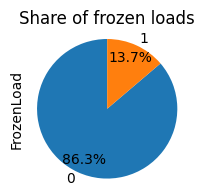

#### Final touches 


In [118]:
# Check missing values again to see if everything has been taken care of 
columns_to_drop = ["StartLegLocationId", "EndLegLocationId", "TransportId", "LoadMetres", "CubicMetres", "Length", "Width", "Height", "GrossWeight", "FullLoadIndicator", "EmptyBookingIndicator"]

# Dropping columns
df_final = df_final.drop(columns_to_drop, axis = 1)

# Check dataset 
df_final.head()


,BookingId,SubBookingName,SubBookingLegId,FromLocation,ToLocation,StartRequestedDate,EndRequestedDate,Temperature,FromLatitude,FromLongitude,FromCity,FromCountry,ToLatitude,ToLongitude,ToCity,ToCountry,Customer Name,RouteDistance,FrozenLoad
0,7399574,A,8266605,33476,32187,2020-12-31,2020-12-31,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,2967,46.346,0
1,7399575,A,8266607,9315,57536,2020-12-31,2020-12-31,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,8190,78.192,0
2,7399576,A,8266606,9315,57536,2020-12-31,2020-12-31,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,8190,78.192,0
3,7399577,A,8266608,5900,9799,2020-12-31,2020-12-31,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,4742,17.733,0
4,7399578,A,8266609,5900,3171,2020-12-31,2020-12-31,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,4742,369.340,0


In [120]:
df_final.isna().sum()

BookingId                   0
SubBookingName              0
SubBookingLegId             0
FromLocation                0
ToLocation                  0
StartRequestedDate        338
EndRequestedDate            0
Temperature           4048923
FromLatitude                0
FromLongitude               0
FromCity                    0
FromCountry                 0
ToLatitude                  0
ToLongitude                 0
ToCity                      2
ToCountry                   0
Customer Name               0
RouteDistance               0
FrozenLoad                  0
dtype: int64

In [121]:
columns = list(df_final.columns)
print(columns)

['BookingId', 'SubBookingName', 'SubBookingLegId', 'FromLocation', 'ToLocation', 'StartRequestedDate', 'EndRequestedDate', 'Temperature', 'FromLatitude', 'FromLongitude', 'FromCity', 'FromCountry', 'ToLatitude', 'ToLongitude', 'ToCity', 'ToCountry', 'Customer Name', 'RouteDistance', 'FrozenLoad']


In [122]:
# Order columns of dataset meaningful 

# Define the desired order of columns
column_order = ['BookingId', 'SubBookingName', 'Customer Name', 'StartRequestedDate', 'EndRequestedDate', 'FromLocation', 'ToLocation', 'FromLatitude', 'FromLongitude', 'FromCity', 'FromCountry', 'ToLatitude', 'ToLongitude', 'ToCity', 'ToCountry', 'DomesticDelivery', 'RouteDistance', 'Temperature', 'FrozenLoad']

# Use the reindex() method to reorder the columns in the dataframe
df_final = df_final.reindex(columns = column_order)

In [124]:
# Look at final dataset

df_final.head(10)

,BookingId,SubBookingName,Customer Name,StartRequestedDate,EndRequestedDate,FromLocation,ToLocation,FromLatitude,FromLongitude,FromCity,FromCountry,ToLatitude,ToLongitude,ToCity,ToCountry,DomesticDelivery,RouteDistance,Temperature,FrozenLoad
0,7399574,A,2967,2020-12-31,2020-12-31,33476,32187,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,1,46.346,NaN,0
1,7399575,A,8190,2020-12-31,2020-12-31,9315,57536,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1,78.192,NaN,0
2,7399576,A,8190,2020-12-31,2020-12-31,9315,57536,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1,78.192,NaN,0
3,7399577,A,4742,2020-12-31,2020-12-31,5900,9799,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,1,17.733,NaN,0
4,7399578,A,4742,2020-12-31,2020-12-31,5900,3171,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,1,369.340,NaN,0
5,7399579,A,8061,2020-12-31,2020-12-31,9194,37657,53.50446,-2.84867,Liverpool,United Kingdom,55.91412,-3.50947,LIVINGSTON,United Kingdom,1,362.516,NaN,0
6,7399580,A,4742,2020-12-31,2020-12-31,5900,29572,53.77629,-1.52585,Leeds,United Kingdom,53.58155,-1.52633,Barnsley,United Kingdom,1,27.685,NaN,0
7,7399581,A,4742,2020-12-31,2020-12-31,5900,11792,53.77629,-1.52585,Leeds,United Kingdom,53.62632,-1.35656,Pontefract,United Kingdom,1,29.779,NaN,0
8,7399582,A,8190,2020-12-30,2020-12-31,37465,21160,53.84792,-2.19863,Colne,United Kingdom,53.50446,-2.84867,Liverpool,United Kingdom,1,79.157,NaN,0
9,7399583,A,7665,2020-12-31,2020-12-31,9194,78230,53.50446,-2.84867,Liverpool,United Kingdom,53.51131,-1.12540,Doncaster,United Kingdom,1,167.201,NaN,0


At this point, EDA and Pre-Processingof the data we received from DFDS is done. 
The last step now is to create two datasets for the following steps. 

1) For visualizations in Tableau, we keep 'df_final' but we rename it to 'df_deliveries' to emphasize that it is delivery-based, meaning every row represents one delivery. 

In [126]:
df_deliveries = df_final

# Saving df_deliveries
df_deliveries.to_csv('df_deliveries.csv', index=False)

2. For building the graph in the next steps, the dataframe df_final needs to be transformed. 
Currently, each row represents one delivery. However, we do need to transform this dataset in a way that every row represents a unique route. 
To do so, we again work with the 'routes_with_distance' dataset we created before.

Please find a more detailed explanation of these important steps and why they were necessary in the report.

In [127]:
# Print number of unique routes
print("Number of unique routes:", len(routes_with_distance))

Number of unique routes: 206865


In [7]:
# Drop duplicates from df_final based on the four coordinate variables
df_final_unique = df_final.drop_duplicates(subset=['FromLatitude', 'FromLongitude', 'ToLatitude', 'ToLongitude'])

# Select the columns to merge from df_final
columns_to_merge = ['FromLatitude', 'FromLongitude', 'ToLatitude', 'ToLongitude',
                    'FromLocation', 'ToLocation', 'FromCity', 'ToCity', 'FromCountry', 'ToCountry', 'CustomerName']

# Merge the two dataframes on the four coordinate variables
df_routes = pd.merge(routes_with_distance, df_final_unique[columns_to_merge], on=['FromLatitude', 'FromLongitude', 'ToLatitude', 'ToLongitude'])

In [136]:
len(df_routes)

197129

In [8]:
# Count the frequency of each unique route in df_final
route_frequency = df_final.groupby(['FromLatitude', 'FromLongitude', 'ToLatitude', 'ToLongitude']).size().reset_index(name='RouteCount')

# Merge the frequency information with merged_df
df_routes = pd.merge(df_routes, route_frequency, on=['FromLatitude', 'FromLongitude', 'ToLatitude', 'ToLongitude'])

In [143]:
# Check if merge etc. worked
df_routes.head()

,FromLatitude,FromLongitude,ToLatitude,ToLongitude,RouteDistance,FromLocation,ToLocation,FromCity,ToCity,FromCountry,ToCountry,CustomerName,RouteCount
0,53.51131,-1.12540,53.60475,-0.65636,46.346,33476,32187,YORKSHIRE,SCUNTHORPE,United Kingdom,United Kingdom,2967,1
1,53.50446,-2.84867,53.04612,-2.92787,78.192,9315,57536,Liverpool,Wrexham,United Kingdom,United Kingdom,8190,53
2,53.77629,-1.52585,53.71874,-1.41235,17.733,5900,9799,Leeds,YORKSHIRE,United Kingdom,United Kingdom,4742,192
3,53.77629,-1.52585,55.87784,-3.65235,369.340,5900,3171,Leeds,Bathgate,United Kingdom,United Kingdom,4742,3
4,53.50446,-2.84867,55.91412,-3.50947,362.516,9194,37657,Liverpool,LIVINGSTON,United Kingdom,United Kingdom,8061,639


In [144]:
# Sanity check: Does the total amount of routes add up? 
df_routes['RouteCount'].sum()

4973604

In [ ]:
# average distance excluding 0

In [10]:
# Sorting routes by RouteCount
df_routes = df_routes.sort_values(by = ['RouteCount'], ascending = False)
df_routes.head()

,FromLatitude,FromLongitude,ToLatitude,ToLongitude,RouteDistance,FromLocation,ToLocation,FromCity,ToCity,FromCountry,ToCountry,CustomerName,RouteCount
152382,57.71873,11.82862,57.71873,11.82862,0.000,968,77695,Skara,Göteborg,Sweden,Sweden,12414,240268
190150,55.47409,9.15797,55.47409,9.15797,0.000,8409,2301,Horsens,Vejen,Denmark,Denmark,12895,195961
22250,57.71877,11.82920,57.69555,11.85303,5.714,30251,70713,Gothenburg,Göteborg,Sweden,Sweden,12895,172307
23781,57.71877,11.82920,57.71225,11.96575,12.148,30251,70709,Gothenburg,Göteborg,Sweden,Sweden,12895,132002
152428,57.72323,11.85834,57.72323,11.85834,0.000,945,11641,DESTELDONK,Göteborg,Sweden,Sweden,12895,115222
254,57.71499,11.82177,57.71499,11.82177,0.000,9483,495,Göteborg,Göteborg,Sweden,Sweden,12417,114706
168001,56.63623,9.77687,56.63623,9.77687,0.000,22240,2300,Dublin,Hobro,Denmark,Denmark,4467,78664
112,55.72639,-3.95987,55.72614,-3.96033,0.006,9230,20364,Larkhall,LARKHALL,United Kingdom,United Kingdom,8062,69049
24100,57.71225,11.96575,57.71877,11.82920,14.361,30257,70696,Göteborg,Gothenburg,Sweden,Sweden,12415,51297
152384,57.71872,11.82861,57.71872,11.82861,0.000,11592,81480,Skara,Göteborg,Sweden,Sweden,12414,50553


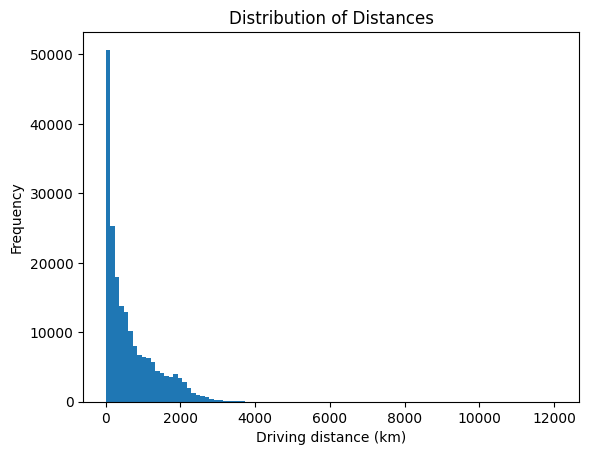

In [148]:
plt.hist(df_routes["RouteDistance"], bins = 100)
plt.xlabel("Driving distance (km)")
plt.ylabel("Frequency")
plt.title("Distribution of Distances")
plt.show()

In [1]:
subset = df_routes[(df_routes['RouteDistance'] < 2500) & (df_routes['RouteDistance']>0)]
plt.hist(subset['RouteDistance'], bins = 100)
plt.xlabel("Driving distance (km)")
plt.ylabel("Frequency")
plt.title("Distribution of Distances")
plt.show()

NameError: name 'df_routes' is not defined

In [ ]:
#country by country graph

In [153]:
# Saving df_routes
df_routes.to_csv('df_routes.csv', index=False)

Creating the df_spike graph

In [ ]:
# Ensuring that only real trips (RouteDistance > 0) are taken into consideration

df_routes=df_routes[df_routes.RouteDistance>0]

In [ ]:
# Creating a variable containing both latitude and longitude for each starting and ending point

df_routes['ToPoint']=list(zip(df_routes.ToLatitude,df_routes.ToLongitude))
df_routes['FromPoint']=list(zip(df_routes.FromLatitude,df_routes.FromLongitude))

In [ ]:
# Calculating the frequency of each starting and ending point 

end_frequency = df_routes['ToPoint'].value_counts().rename_axis('ToPoint').reset_index(name='counts1')
start_frequency = df_routes['FromPoint'].value_counts().rename_axis('FromPoint').reset_index(name='counts2')

In [ ]:
# Renaming columns so that they can be merged together

end_frequency.rename(columns={'ToPoint': 'Point'}, inplace=True)
start_frequency.rename(columns={'FromPoint': 'Point'}, inplace=True)

In [ ]:
# Merge together frequency of starting and ending points, in order to have a summary value

df_spike_graph=end_frequency.merge(start_frequency, on='Point')

In [ ]:
# Split the longitude and latitude into separate variables

df_spike_graph['Latitude']=df_spike_graph['Point'].apply(lambda x:x[0])
df_spike_graph['Longitude']=df_spike_graph['Point'].apply(lambda x:x[1])

In [ ]:
# Find the total frequency for each point

df_spike_graph['PointCounts']=df_spike_graph.counts1+df_spike_graph.counts2

In [ ]:
# Renaming columns

df_spike_graph.rename(columns={'counts1': 'EndPointFrequency', 'counts2':'StartPointFrequency'}, inplace=True)

In [ ]:
df_spike_graph

In [ ]:
# Caluculate total frequency

total=df_spike_graph.PointCounts.sum()
start_total=df_spike_graph.StartPointFrequency.sum()
end_total=df_spike_graph.EndPointFrequency.sum()

In [ ]:
# Espress frequencies as percentage of the total

df_spike_graph['TotPct']=df_spike_graph['PointCounts'].apply(lambda x: (x/total)*100)
df_spike_graph['StartPct']=df_spike_graph['StartPointFrequency'].apply(lambda x: (x/start_total)*100)
df_spike_graph['EndPct']=df_spike_graph['EndPointFrequency'].apply(lambda x: (x/end_total)*100)

In [ ]:
df_spike_graph.to_csv('df_spike_graph.csv')